## Projeto 1 - Métodos de Busca utilizando o jogo Pacman

O problema é composto por um agente (Pacman) e um labirinto. O labirinto é um grid de $n$ linhas e $m$ colunas indexadas de $0$ a $n-1$ e de $0$ a $m-1$ respectivamente, como mostra a Figura 1 abaixo. Áreas em preto representam paredes, áreas em azul representam posições atravessáveis e as bolinhas brancas representam comidas que devem ser coletadas pelo agente. Ladrilhos em cinza representam fantasmas (posições não atravessáveis que devem ser evitadas pelo agente).

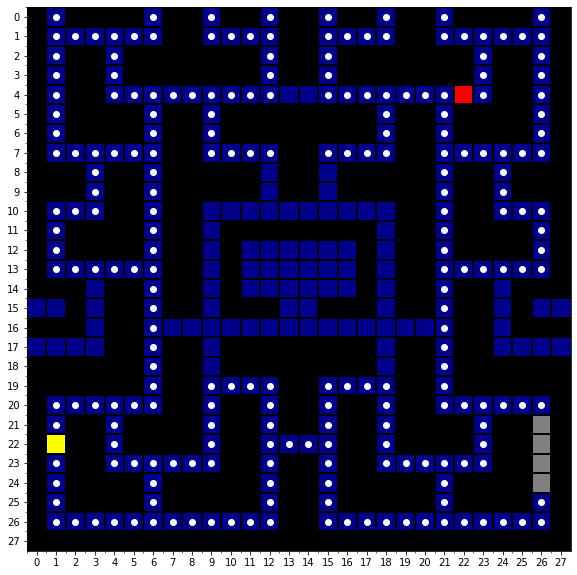


### Labirintos:

Os labirintos utilizados no problema foram criados a partir de modificações (junções) dos labirintos disponíveis em https://github.com/shaunlebron/pacman-mazegen.

### Modelagem do problema:

Um estado é representado por uma dupla $(i, j)$ que indica a posição do pacman, i.e, $i$ indica a linha e $j$ a coluna do labirinto. A armazenagem do labirinto foi feita por meio uma lista de objetos de uma classe Posição. A classe Posição possui as coordenadas $i, j$ do estado e um boolean que é verdadeiro caso a posição seja uma comida ou falso, caso contrário. Apenas as posições atravessáveis e as posições dos fantasmas são armazenadas, ou seja, não são armazenadas as posições que são paredes.

##### Ações: 

Existem quatro ações possíveis para o agente: ir para cima, para baixo, para esquerda e para direita. Não é possível ir para uma posição através de diagonais. O agente pode atravessar de um lado do labirinto para o outro lado através de túneis. Um túnel é representado por duas posições atravessáveis de fronteira de mesma linha ou coluna. As posições $(0, 15)$ e $(27, 15)$ representam um túnel na Figura 1.


### Objetivo:

O objetivo é fazer o agente (pacman) chegar a um estado final, isto é, chegar a uma posição objetivo (x, y), coletando o maior número possível de comidas durante o caminho.


### Heurísticas utilizadas:

- Distância Manhattan:
- Distância Shockwave:
- Evasão de Fantasmas:

### Implementação:

Todos os métodos de busca utilizados foram adaptações dos métodos da biblioteca AIMA disponível em


### Buscas implementadas:

- Sem informação:
    - BFS:
    - DFS:

- Informadas:
	- Busca Gulosa:
	- A*:

- Locais:
	- Hill Climbing:
	- Simulated annealing:

### Testes realizados:

#### Métricas coletadas:

### Resultados:

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

# importa o arquivo e guarda em um dataframe do Pandas
df = pd.read_csv( 'results.csv', sep=',', index_col=None) 
n_alg = 8 #numero de algoritmos
n = 3 * n_alg #numero de testes
df.insert(0,'Maze',"")
df['Maze'] = (df.index/(n)).astype('int32')
df['Custo Caminho'] = 1000*(df['Number of nodes in the path'] - df['Number of food nodes in the path']) + df['Number of food nodes in the path']

In [2]:
df["Maze"].replace({0: "Tiny", 1: "Small", 2:"Medium", 3:"Big"}, inplace=True)

tiny = df.loc[df['Maze'] == "Tiny"]
small = df.loc[df['Maze'] == "Small"]
medium = df.loc[df['Maze'] == "Medium"]
big = df.loc[df['Maze'] == "Big"]

## Tiny Maze

### Tempo e Memória

In [3]:
tiny = tiny.groupby("Busca").mean().round(2)
tiny.sort_values(by=['Tempo']).iloc[:, 0:2]

,Tempo,Maximo tam de Nos na memoria
Busca,,
Greedy Search - Shockwave Heuristic,0.02,15.33
Greedy Search - Manhattan Distance,0.03,17.00
A* Search - Manhattan Distance,0.05,23.33
A* Search - Shockwave Heuristic,0.05,22.00
A* Search - Ghost Avoidance Heuristic with Euclidean Distance,0.06,20.67
DFS,0.07,29.67
BFS,0.10,18.33
Greedy Search - Ghost Avoidance Heuristic with Euclidean Distanc,0.21,20.00


### Nós Expandidos

In [4]:
tiny.sort_values(by=['Custo Caminho']).iloc[:, 2:]

,Number of expanded nodes,Number of expanded food nodes,Number of nodes in the path,Number of food nodes in the path,Custo Caminho
Busca,,,,,
A* Search - Manhattan Distance,109.67,107.33,46.33,45.67,712.33
A* Search - Shockwave Heuristic,104.33,101.67,46.33,45.67,712.33
A* Search - Ghost Avoidance Heuristic with Euclidean Distance,116.67,112.67,49.67,49.00,715.67
BFS,281.33,203.67,37.00,33.00,4033.00
Greedy Search - Shockwave Heuristic,36.00,28.67,37.00,29.33,7696.00
Greedy Search - Manhattan Distance,59.67,42.33,53.00,38.33,14705.00
Greedy Search - Ghost Avoidance Heuristic with Euclidean Distanc,156.33,118.33,57.00,40.67,16374.00
DFS,170.00,116.00,119.67,76.33,43409.67


## Small Maze

### Tempo e Memória

In [5]:
small = small.groupby("Busca").mean().round(2)
small.sort_values(by=['Tempo']).iloc[:, 0:2]

,Tempo,Maximo tam de Nos na memoria
Busca,,
Greedy Search - Shockwave Heuristic,0.10,34.67
Greedy Search - Manhattan Distance,0.14,31.33
Greedy Search - Ghost Avoidance Heuristic with Euclidean Distanc,0.43,41.00
A* Search - Manhattan Distance,0.50,48.00
A* Search - Shockwave Heuristic,0.55,46.33
A* Search - Ghost Avoidance Heuristic with Euclidean Distance,0.58,61.67
DFS,0.62,104.33
BFS,0.78,22.33


### Nós expandidos

In [6]:
small.sort_values(by=['Custo Caminho']).iloc[:, 2:]

,Number of expanded nodes,Number of expanded food nodes,Number of nodes in the path,Number of food nodes in the path,Custo Caminho
Busca,,,,,
A* Search - Manhattan Distance,537.67,505.00,110.67,109.67,1109.67
A* Search - Shockwave Heuristic,508.67,478.00,110.67,109.67,1109.67
A* Search - Ghost Avoidance Heuristic with Euclidean Distance,673.67,640.67,146.00,145.00,1145.00
Greedy Search - Manhattan Distance,129.33,98.33,106.67,83.67,23083.67
BFS,958.00,722.33,94.67,65.67,29065.67
Greedy Search - Shockwave Heuristic,93.67,62.00,94.67,63.00,31729.67
Greedy Search - Ghost Avoidance Heuristic with Euclidean Distanc,513.33,377.33,149.33,102.33,47102.33
DFS,711.33,532.00,308.67,227.67,81227.67


## Medium Maze

### Tempo e Memória

In [7]:
medium = medium.groupby("Busca").mean().round(2)
medium.sort_values(by=['Tempo']).iloc[:, 0:2]

,Tempo,Maximo tam de Nos na memoria
Busca,,
Greedy Search - Shockwave Heuristic,0.19,45.33
Greedy Search - Manhattan Distance,0.34,50.33
Greedy Search - Ghost Avoidance Heuristic with Euclidean Distanc,2.57,73.33
DFS,2.79,232.67
BFS,3.21,47.33
A* Search - Manhattan Distance,4.76,134.67
A* Search - Ghost Avoidance Heuristic with Euclidean Distance,5.10,152.67
A* Search - Shockwave Heuristic,5.51,144.00


### Nós expandidos

In [8]:
medium.sort_values(by=['Custo Caminho']).iloc[:, 2:]

,Number of expanded nodes,Number of expanded food nodes,Number of nodes in the path,Number of food nodes in the path,Custo Caminho
Busca,,,,,
A* Search - Manhattan Distance,2194.33,1825.67,155.33,149.00,6482.33
A* Search - Shockwave Heuristic,2260.33,1895.00,155.33,149.00,6482.33
A* Search - Ghost Avoidance Heuristic with Euclidean Distance,2396.67,1986.67,213.33,207.00,6540.33
Greedy Search - Manhattan Distance,163.00,115.67,118.67,92.67,26092.67
Greedy Search - Shockwave Heuristic,68.33,40.67,69.33,41.33,28041.33
BFS,1531.33,1151.33,69.33,41.00,28374.33
Greedy Search - Ghost Avoidance Heuristic with Euclidean Distanc,1220.67,893.00,95.33,52.33,43052.33
DFS,1271.00,966.00,712.00,556.00,156556.00


## Big Maze

### Tempo e Memória

In [9]:
big = big.groupby("Busca").mean().round(2)
big.sort_values(by=['Tempo']).iloc[:, 0:2]

,Tempo,Maximo tam de Nos na memoria
Busca,,
Greedy Search - Shockwave Heuristic,0.69,71.67
Greedy Search - Manhattan Distance,4.54,95.00
DFS,11.98,614.33
Greedy Search - Ghost Avoidance Heuristic with Euclidean Distanc,14.92,180.00
A* Search - Ghost Avoidance Heuristic with Euclidean Distance,15.72,246.67
BFS,16.03,73.67
A* Search - Manhattan Distance,17.06,256.67
A* Search - Shockwave Heuristic,19.65,268.33


### Nós expandidos

In [10]:
big.sort_values(by=['Custo Caminho']).iloc[:, 2:]

,Number of expanded nodes,Number of expanded food nodes,Number of nodes in the path,Number of food nodes in the path,Custo Caminho
Busca,,,,,
A* Search - Manhattan Distance,3828.33,3226.33,203.00,199.00,4199.00
A* Search - Shockwave Heuristic,3800.67,3212.33,203.00,199.00,4199.00
A* Search - Ghost Avoidance Heuristic with Euclidean Distance,3696.33,3001.67,265.00,261.00,4261.00
BFS,3961.00,3058.67,153.00,112.00,41112.00
Greedy Search - Shockwave Heuristic,152.00,104.67,153.00,105.67,47439.00
Greedy Search - Manhattan Distance,1089.00,815.00,265.67,172.67,93172.67
Greedy Search - Ghost Avoidance Heuristic with Euclidean Distanc,3645.33,2774.00,400.33,300.33,100300.33
DFS,3008.67,2324.33,1097.67,849.67,248849.67


In [11]:
def make_plot(feature):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.scatter(big.index, big[feature], label="Big", marker='P')
    ax.scatter(medium.index, medium[feature], label="Medium", marker='X')
    ax.scatter(small.index, small[feature], label="Small", marker='D')
    ax.scatter(tiny.index, tiny[feature], label="Tiny", marker='o')
    ax.legend()
    plt.ylabel(feature)
    plt.xticks(rotation=80)
    plt.show()

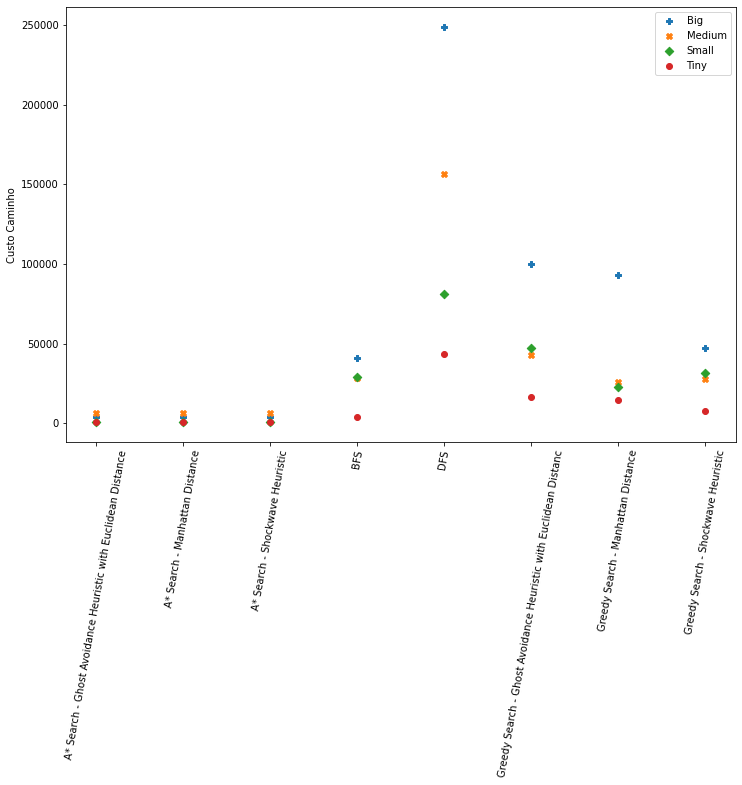

In [12]:
make_plot("Custo Caminho")

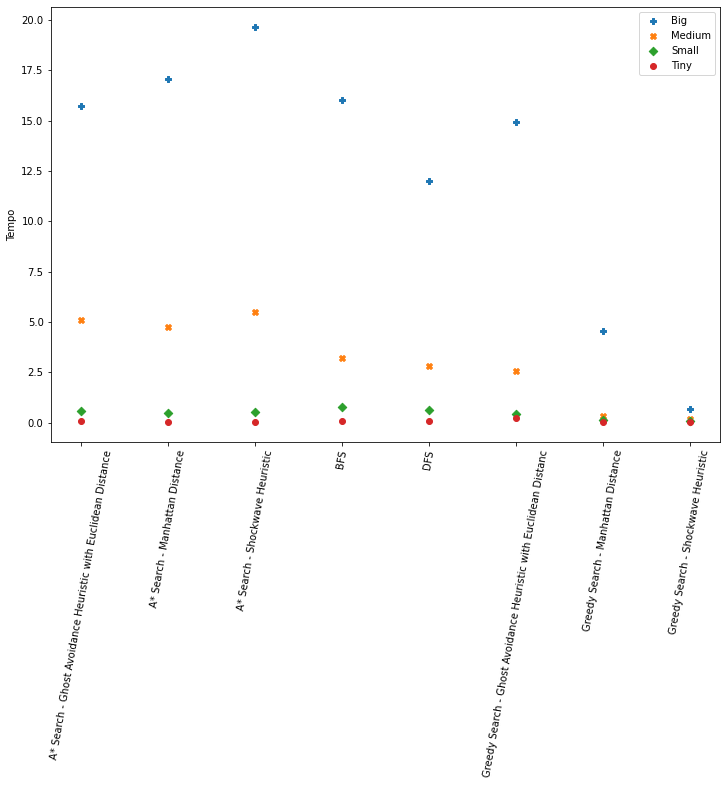

In [13]:
make_plot('Tempo')

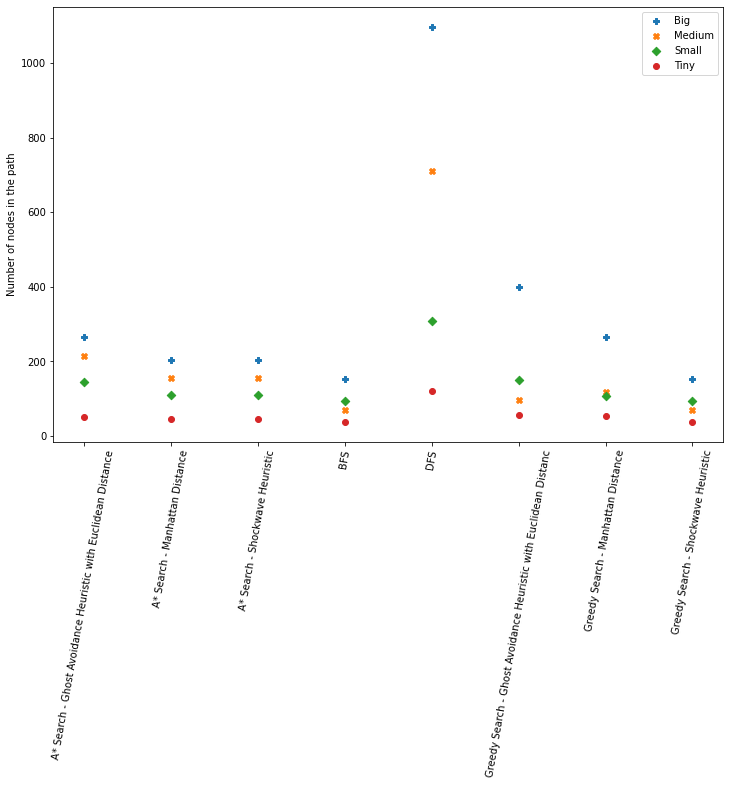

In [14]:
make_plot('Number of nodes in the path')

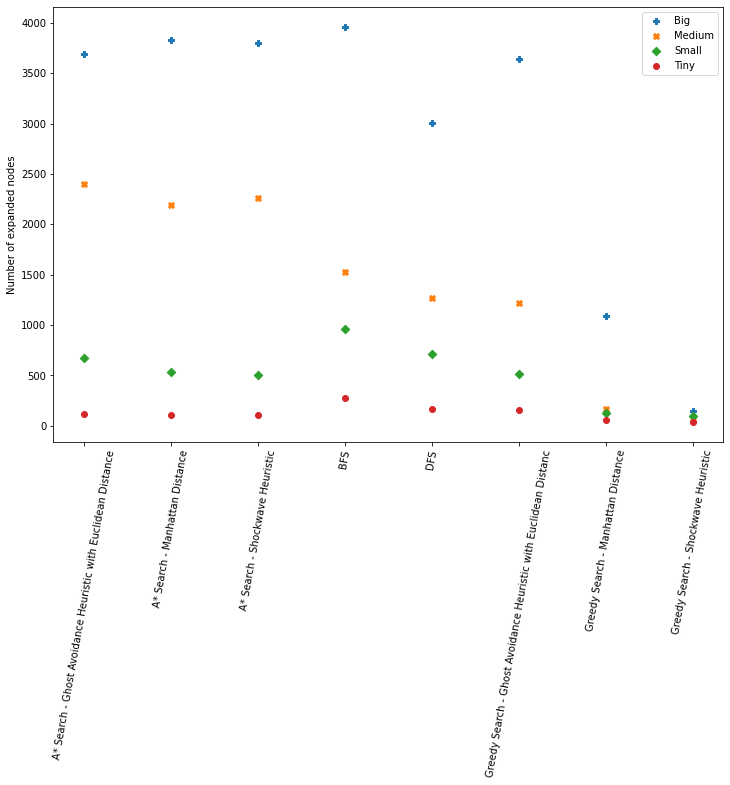

In [15]:
make_plot('Number of expanded nodes')

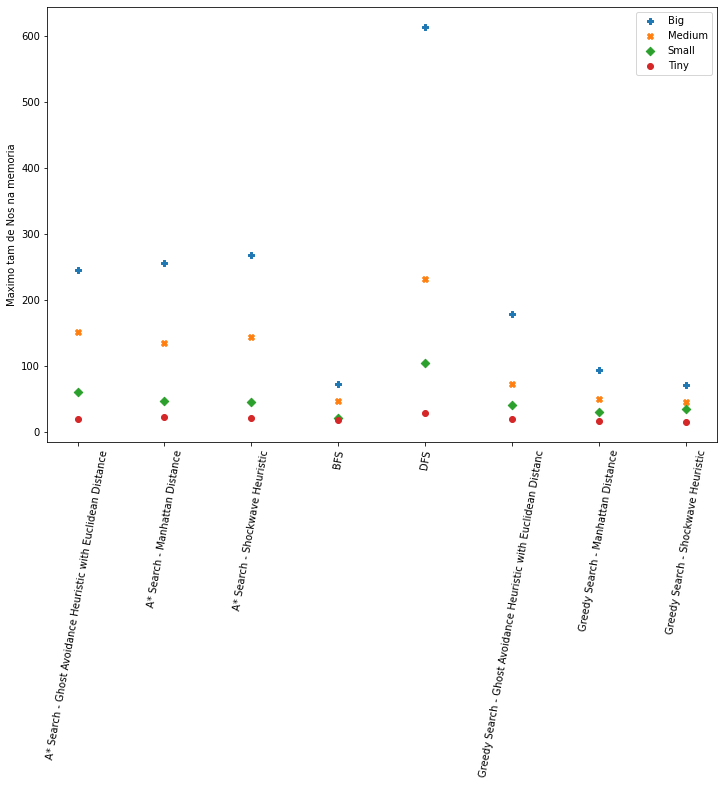

In [16]:
make_plot('Maximo tam de Nos na memoria')